In [1]:
!rm -rf model_discovery
!rm -rf data
import gdown
# download source code
gdown.download('https://drive.google.com/uc?id=1exw9vOYcb0fPVseleifK0m1VxbBCsBM_', output=None, quiet=False)
# download data
gdown.download('https://drive.google.com/uc?id=1ozrvNU128WOGWDVhhDKtZENzBMuO-w4i', output=None, quiet=False)

!unzip -qq data.zip
!unzip -qq model_discovery.zip

Downloading...
From: https://drive.google.com/uc?id=1exw9vOYcb0fPVseleifK0m1VxbBCsBM_
To: /content/model_discovery.zip
100%|██████████| 11.9k/11.9k [00:00<00:00, 9.34MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ozrvNU128WOGWDVhhDKtZENzBMuO-w4i
To: /content/data.zip
22.5MB [00:00, 58.6MB/s]


In [4]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import model_discovery
from collections import Counter, defaultdict
from importlib import reload
from matplotlib import gridspec
from tqdm.notebook import trange, tqdm
from sklearn.model_selection import train_test_split
from model_discovery import utils, l2lsh, my_timer



In [5]:
dir_path = ''
ar_data = np.load(dir_path + 'data/activity_recognition/activity_recognition_full.npy', allow_pickle=True).item()

In [6]:
datasets = ['dsads_t', 'dsads_ra', 'dsads_la', 
            'dsads_rl', 'dsads_ll', 'oppo_b', 
            'oppo_rua', 'oppo_rla', 'oppo_lua',
            'oppo_lla', 'pamap_w', 'pamap_c',
            'pamap_a']

combinations = itertools.combinations(datasets,2)
combinations = list(combinations)

permutations = itertools.permutations(datasets,2)
permutations = list(permutations)

## Validate the JS-Divergence can be estimated by squared hellinger distance

proposed by 
```
Chen, L., Esfandiari, H., Fu, G., & Mirrokni, V. (2019). Locality-sensitive hashing for f-divergences: Mutual information loss and beyond. Advances in Neural Information Processing Systems, 32, 10044-10054.
```

In [7]:
# Figure JSD vs. HSD

jsd = []
shd = []

for comb in tqdm(combinations, leave=False):
    data1 = ar_data[comb[0]]
    data2 = ar_data[comb[1]]

    for i in range(data1.shape[1]):
        col1 = data1[:, i]
        col2 = data2[:, i]

        prob1 = utils.data_to_probability(col1, 100)
        prob2 = utils.data_to_probability(col2, 100)

        jsd.append(utils.jensen_shannon_divergence(prob1, prob2))
        shd.append(utils.squared_hellinger_distance(prob1, prob2))  

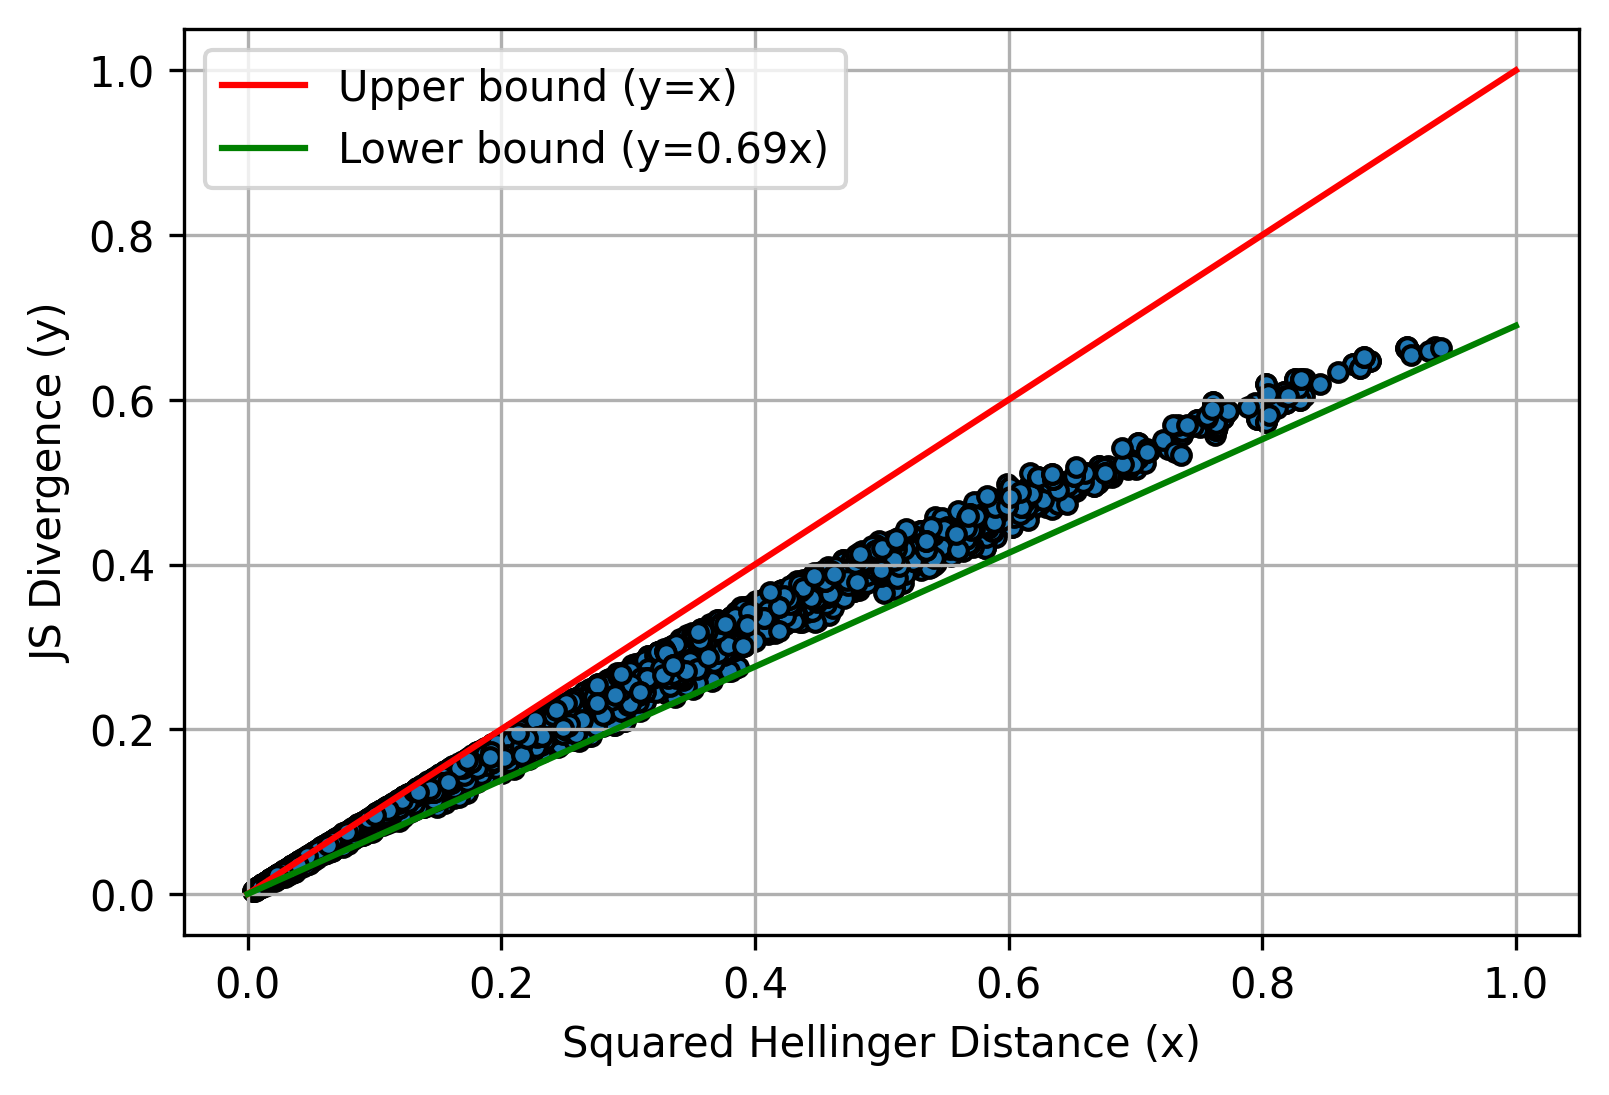

In [8]:
plt.figure(figsize=(6,4), dpi=300)
plt.scatter(shd, jsd, s=20, edgecolor='black')
a = np.linspace(0, 1, 100)
plt.grid()
plt.plot(a, a, c='red', label='Upper bound (y=x)')
plt.plot(a, 0.69*a, c='green', label='Lower bound (y=0.69x)')
plt.xlabel('Squared Hellinger Distance (x)')
plt.ylabel('JS Divergence (y)')
plt.legend()
plt.show()

In [9]:
def look_up_labels(data):
  if data in ['dsads_t', 'dsads_ra', 'dsads_la', 'dsads_rl', 'dsads_ll']:
    return 'dsads_label'
  elif data in ['oppo_b', 'oppo_rua', 'oppo_rla', 'oppo_lua', 'oppo_lla']:
    return 'oppo_label'
  elif data in ['pamap_w', 'pamap_c', 'pamap_a']:
    return 'pamap_label'

def nn_finetune(src_x, src_y, tar_x, tar_y, src_t_size=0.2, tar_t_size=0.8, verbose=0):
  src_x_train, src_x_test, src_y_train, src_y_test = train_test_split(src_x, src_y, test_size=src_t_size, random_state=0)
  tar_x_train, tar_x_test, tar_y_train, tar_y_test = train_test_split(tar_x, tar_y, test_size=tar_t_size, random_state=0)
  
  input_size = src_x.shape[1]
  src_output_size = len(np.unique(src_y))
  tar_output_size = len(np.unique(tar_y))

  model_src = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(input_size, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(src_output_size, activation='softmax')
  ])

  model_src.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['mae', 'acc'])
  model_src.fit(src_x_train, src_y_train, epochs=15, verbose=verbose)
  print('Source Domain NN Accuracy')
  src_acc = model_src.evaluate(src_x_test, src_y_test, verbose=1)

  # Finetune
  model_tar = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(input_size, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(tar_output_size, activation='softmax')
  ])

  model_tar.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['mae', 'acc'])
  
  model_tar.layers[1].set_weights(model_src.layers[1].get_weights())
  model_tar.layers[1].trainable = False

  print('Serving Accuracy');
  ser_acc = model_src.evaluate(tar_x_test, tar_y_test, verbose=1)

  model_tar.fit(tar_x_train, tar_y_train, epochs=15, verbose=verbose)
  print('Fine-tunned model trained with tar domain size ', 1 - tar_t_size,
        'Train size: ', tar_x_train.shape[0], 'Test size: ', tar_x_test.shape[0])
  ft_acc = model_tar.evaluate(tar_x_test, tar_y_test, verbose=1)

  return [src_acc, ser_acc, ft_acc]

In [10]:
# Figure exhaust combination of AR to compute JSD

src = []
tar = []
jsd = []
l2d = []

source = [] 
serving = []
finetune = []

for comb in tqdm(permutations, leave=False):
    # Retrieve Data
    data1 = ar_data[comb[0]]
    data1_label = ar_data[look_up_labels(comb[0])]
    data2 = ar_data[comb[1]]
    data2_label = ar_data[look_up_labels(comb[1])]
    
    # Calculate JSD
    prob1 = utils.data_to_probability(data1, bins=100)
    prob2 = utils.data_to_probability(data2, bins=100)

    # Calculate L2D
    center1 = utils.data_to_center(data1)
    center2 = utils.data_to_center(data2)
    
    src.append(comb[0])
    tar.append(comb[1])
    jsd.append(utils.jensen_shannon_divergence(prob1, prob2))
    l2d.append(utils.l2_distance(center1, center2))

    accs = nn_finetune(data1, data1_label, data2, data2_label,src_t_size=0.2, tar_t_size=0.8, verbose=0)
    source.append(accs[0][2])    
    serving.append(accs[1][2])
    finetune.append(accs[2][2])

Source Domain NN Accuracy
12/12 [==============================] - 0s 1ms/step - loss: 0.7347 - mae: 1.3854 - acc: 0.6406
Serving Accuracy
48/48 [==============================] - 0s 1ms/step - loss: 0.8152 - mae: 1.3799 - acc: 0.5339
Fine-tunned model trained with tar domain size  0.19999999999999996 Train size:  384 Test size:  1536
48/48 [==============================] - 0s 1ms/step - loss: 0.6538 - mae: 1.3799 - acc: 0.7038
Source Domain NN Accuracy
12/12 [==============================] - 0s 1ms/step - loss: 0.7480 - mae: 1.3854 - acc: 0.6484
Serving Accuracy
48/48 [==============================] - 0s 1ms/step - loss: 0.8028 - mae: 1.3799 - acc: 0.5833
Fine-tunned model trained with tar domain size  0.19999999999999996 Train size:  384 Test size:  1536
48/48 [==============================] - 0s 1ms/step - loss: 0.6582 - mae: 1.3799 - acc: 0.7122
Source Domain NN Accuracy
12/12 [==============================] - 0s 1ms/step - loss: 0.7490 - mae: 1.3854 - acc: 0.6406
Serving Accu

In [11]:
result = pd.DataFrame({'src': src, 'tar': tar, 'l2d': l2d, 'jsd': jsd, 'source_acc': source, 'serving': serving, 'finetune': finetune})

In [12]:
pd.set_option('display.max_rows', 200)
result.sort_values(by=['tar', 'serving'], ascending=False)

,src,tar,l2d,jsd,source_acc,serving,finetune
142,pamap_c,pamap_w,0.622451,0.005972,0.921697,0.597715,0.710322
154,pamap_a,pamap_w,0.743870,0.014660,0.737357,0.439412,0.729906
57,dsads_ll,pamap_w,1.729038,0.044448,0.630208,0.267646,0.664627
69,oppo_b,pamap_w,1.384871,0.041871,0.918408,0.234598,0.771930
81,oppo_rua,pamap_w,1.251849,0.052333,0.882587,0.234598,0.745818
105,oppo_lua,pamap_w,1.277806,0.051026,0.879602,0.231742,0.762138
21,dsads_ra,pamap_w,1.578720,0.032859,0.718750,0.228886,0.695226
45,dsads_rl,pamap_w,1.791822,0.048892,0.687500,0.203998,0.696858
9,dsads_t,pamap_w,1.713112,0.041491,0.575521,0.178295,0.702570
117,oppo_lla,pamap_w,1.100290,0.049828,0.838806,0.173399,0.744594
